## Customer Segmentation by RFM model and K-Means.

In [1]:
# import modules
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import os

import random
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
sns.set()

In [2]:
files=[]
for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        files.append(os.path.join(dirname, filename))
        
frame=[]
for i in range(len(files)):
    temp_df=pd.read_csv(files[i])
    temp_df['month']=files[i][-7:-4]
    frame.append(temp_df)
df=pd.concat(frame,ignore_index=True,sort=False)

print("The dataframe has {} rows and {} columns.\n".format(df.shape[0],df.shape[1]))
print("Shown below are the first 3 rows of the dataframe:\n")
pd.set_option('display.max_columns', 100)
df.head()

The dataframe has 20692840 rows and 10 columns.

Shown below are the first 3 rows of the dataframe:



,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,month
0,2019-11-01 00:00:02 UTC,view,5802432,1487580009286598681,NaN,NaN,0.32,562076640,09fafd6c-6c99-46b1-834f-33527f4de241,Nov
1,2019-11-01 00:00:09 UTC,cart,5844397,1487580006317032337,NaN,NaN,2.38,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb,Nov
2,2019-11-01 00:00:10 UTC,view,5837166,1783999064103190764,NaN,pnb,22.22,556138645,57ed222e-a54a-4907-9944-5a875c2d7f4f,Nov
3,2019-11-01 00:00:11 UTC,cart,5876812,1487580010100293687,NaN,jessnail,3.16,564506666,186c1951-8052-4b37-adce-dd9644b1d5f7,Nov
4,2019-11-01 00:00:24 UTC,remove_from_cart,5826182,1487580007483048900,NaN,NaN,3.33,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb,Nov


### Data preparation

In [3]:
df_purchased=df.loc[df.event_type=='purchase',:]

df_purchased=df_purchased.drop(columns=['category_code','brand','product_id','category_id','user_session'])

df_purchased=df_purchased.drop_duplicates()

df_purchased['event_time']=pd.to_datetime(df_purchased['event_time'],infer_datetime_format=True)

nullcolumns=df_purchased.isnull().sum()
nullnumbers=len(nullcolumns[nullcolumns!=0])
print("After data selection and cleansing, the dataframe has {} rows, {} columns, and {} null value.\n".format(df_purchased.shape[0],df_purchased.shape[1],nullnumbers))
df_purchased.head()

After data selection and cleansing, the dataframe has 908776 rows, 5 columns, and 0 null value.



,event_time,event_type,price,user_id,month
30,2019-11-01 00:01:57+00:00,purchase,3.16,460304619,Nov
32,2019-11-01 00:01:57+00:00,purchase,17.46,460304619,Nov
33,2019-11-01 00:01:57+00:00,purchase,22.54,460304619,Nov
61,2019-11-01 00:04:33+00:00,purchase,5.24,564451209,Nov
62,2019-11-01 00:04:33+00:00,purchase,7.16,564451209,Nov


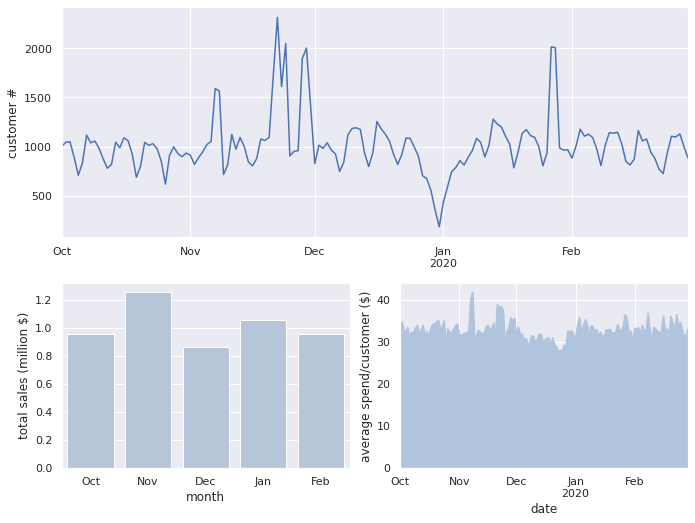

In [4]:
# initial data exploration

plt.figure(figsize=(10,8))

# plot the number of customers each day 
plt.axes([0.08, 0.4, 0.87, 0.4])
df_sales_n_user=df_purchased.resample("D",on='event_time')['user_id'].nunique()
df_sales_n_user.plot(kind='line')
plt.xlabel('')
plt.ylabel('customer #')

# plot total sales/month 
plt.axes([0.08,0,0.4,0.32])
a=df_purchased.resample('M',on='event_time')['price'].sum().to_frame()
a['month']=['Oct','Nov','Dec',"Jan", "Feb"]
a['price']=a['price']/1000000
sns.barplot(x='month',y='price',data=a,color="lightsteelblue")
plt.xlabel('month')
plt.ylabel('total sales (million $)')

# plot average spend/customer
plt.axes([0.55,0,0.4,0.32])
df_sales_p_day=df_purchased.resample('D',on='event_time')['price'].sum()
df_sales_spent=df_sales_p_day/df_sales_n_user
df_sales_spent.plot(kind='area',color="lightsteelblue")
plt.xlabel('date')
plt.ylabel('average spend/customer ($)');

In [ ]:
# group the data by "user_id", and calcualte each customer's recency, frequency, and monetary value

# step 1: calculate "Recency", set Feb 2020 as the reference month, and use "month" as the unit
d={"Oct":4,"Nov":3,"Dec":2,"Jan":1,"Feb":0}
df_purchased.loc[:,'Recency']=df_purchased['month'].map(d)
df_R=df_purchased.groupby('user_id')['Recency'].min().reset_index().rename(columns={"0":"Recency"})

# step 2: calculate "Frequency"
df_F=df_purchased.groupby('user_id')['event_type'].count().reset_index().rename(columns={"event_type":"Frequency"})

# step 3: calculate "Monetary"
df_M=df_purchased.groupby('user_id')['price'].sum().reset_index().rename(columns={"price":"Monetary"})

# step 4: merge "Recency", "Frequency", and "Monetary"
df_RF=pd.merge(df_R,df_F,on='user_id')
df_RFM=pd.merge(df_RF,df_M,on='user_id')

# step 5: remove outliers before K-Means clustering
conditions=np.abs(stats.zscore(df_RFM.loc[:,['Recency','Frequency','Monetary']]) < 3).all(axis=1)
df_RFM2=df_RFM.loc[conditions,:]

df_RFM2.head()

,user_id,Recency,Frequency,Monetary
0,9794320,3,2,7.72
1,10079204,3,2,25.81
2,10280338,0,19,63.29
3,12055855,2,4,16.54
4,12936739,1,2,29.89


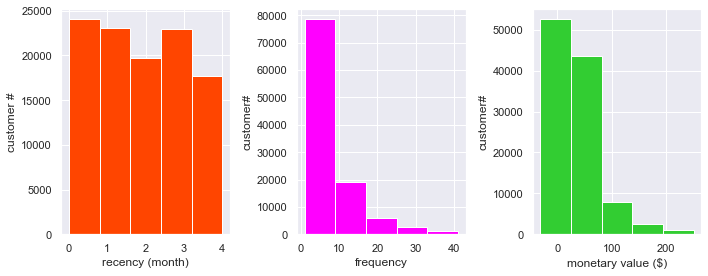

In [ ]:
# visualize the distribution of "Recency", "Frequency", and "Monetary"
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(10,4))

# plot "Recency"
ax1.hist(df_RFM2['Recency'],bins=5,color='orangered')
ax1.set_xticks(np.arange(0,5,1))
ax1.set_xlabel('recency (month)')
ax1.set_ylabel('customer #')

# plot "Frequency"
ax2.hist(df_RFM2['Frequency'],bins=5,color='fuchsia')
ax2.set_xlabel('frequency')
ax2.set_ylabel('customer#')

# plot "Monetary"
ax3.hist(df_RFM2['Monetary'],bins=5,color='limegreen')
ax3.set_xlabel('monetary value ($)')
ax3.set_ylabel('customer#')

plt.tight_layout()

In [22]:
# df_RFM2.to_csv('final_dataset.csv', index=False)

### Customer Segmentation by RFM-Based K-Means Clustering

In [2]:
df_RFM2 = pd.read_csv('final_dataset_rfm.csv')
df_RFM2

,user_id,Recency,Frequency,Monetary
0,9794320,3,2,7.72
1,10079204,3,2,25.81
2,10280338,0,19,63.29
3,12055855,2,4,16.54
4,12936739,1,2,29.89
...,...,...,...,...
107501,622065819,0,2,14.76
107502,622066161,0,4,12.95
107503,622067983,0,9,64.91
107504,622069477,0,1,0.95


In [3]:
# k-means clustering: using recency, frequency, and monetary as clustering varaibles

# step 1: standardize data
df_RFM3=df_RFM2.drop(columns=['user_id'])
X = StandardScaler().fit_transform(df_RFM3)


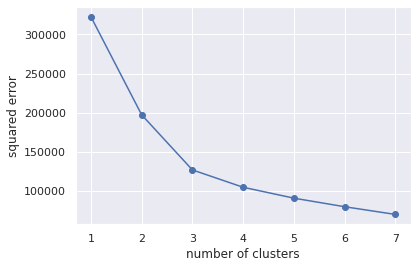

In [5]:
# step 2: find the optimal number of clusters
SSE=[]
for i in range(1,8):
    kmeans=KMeans(n_clusters=i)
    kmeans.fit(X)
    SSE.append(kmeans.inertia_)
sns.set()
plt.plot(range(1,8,1),SSE,marker='o')
plt.xlabel('number of clusters')
plt.ylabel('squared error');

/tmp/ipykernel_140677/4224084853.py:26: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax=Axes3D(fig)


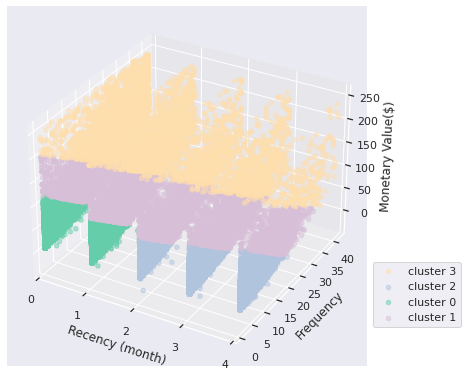

In [4]:
# k-means clustering: using recency, frequency, and monetary as clustering varaibles
df_RFM2_original = df_RFM2.copy()
# step 3: group customers into 4 clusters
random.seed(8)
km=KMeans(n_clusters=4,random_state=0)
km.fit(X)
random.seed(8)
pred=km.predict(X)
df_RFM2=df_RFM2.assign(clusters=pred)

# step 4: visualize the 4 clusters

# step 4_1: data preparation
R=[]
F=[]
M=[]
mycolors=['navajowhite','lightsteelblue','mediumaquamarine','thistle']
cluster_orders=[3,2,0,1]
for i in [0,1,2,3]:
    R.append(df_RFM2.loc[df_RFM2.clusters==cluster_orders[i],'Recency'].values.tolist())
    F.append(df_RFM2.loc[df_RFM2.clusters==cluster_orders[i],'Frequency'].values.tolist())
    M.append(df_RFM2.loc[df_RFM2.clusters==cluster_orders[i],'Monetary'].values.tolist())
    
# step 4_2: 3D scatter plot
fig=plt.figure(figsize=(8,5))
ax=Axes3D(fig)
for i in [0,1,2,3]:
    ax.scatter(R[i], F[i], M[i], c=mycolors[i], marker='o',alpha=0.5,label='cluster '+str(cluster_orders[i]))
ax.set_xlabel('Recency (month)')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary Value($)')
ax.set_xlim(0,4)
ax.set_xticks(list(range(5)))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.2))
plt.show()

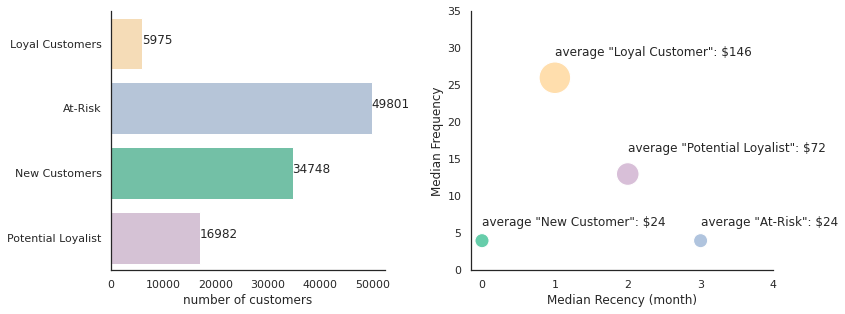

In [5]:
d1={0:"New Customers", 1:"Potential Loyalist", 2: "At-Risk", 3:"Loyal Customers"}
df_RFM2.loc[:,"segments"]=df_RFM2.loc[:,"clusters"].map(d1)

# calculate the number of customers, median recency, median frequency, 
# and average customer spend in each customer segment
df_RFM3=df_RFM2.groupby('segments').agg(Recency=('Recency',np.median),Frequency=('Frequency',np.median),MonetarySum=('Monetary',np.sum),size=("clusters",'size'))
df_RFM3.loc[:,'Sales/Customer']=round(df_RFM3.loc[:,'MonetarySum']/df_RFM3.loc[:,'size'])
df_RFM3=df_RFM3.astype({'Sales/Customer':int}).reset_index()

# visualize
plt.figure(figsize=(10,4))
seg_names=['Loyal Customers','At-Risk','New Customers','Potential Loyalist']

# plot the number of customers in each segment
sns.set_style("white")
plt.axes([0, 0, 0.38, 0.9])
seg=df_RFM2.groupby('segments').size().to_frame().rename(columns={0:'number of customers'}).reset_index()
sns.barplot(x='number of customers',y='segments',data=seg,order=seg_names,palette=mycolors)
for i in [0,1,2,3]:
    number=int(seg.loc[seg.segments==seg_names[i],'number of customers'])
    x_pos=round(number,-2)
    plt.text(x_pos,i,number)
plt.ylabel("")
sns.despine()

# plot recency, frequency, and average spend/customer of the 4 segments
plt.axes([0.5,0,0.42,0.9])
sns.scatterplot(x='Recency',y='Frequency',hue='segments',hue_order=seg_names,palette=mycolors,size='Sales/Customer',sizes=(200,1000),legend=False,data=df_RFM3)
plt.ylim(0,35)
plt.xticks(list(range(5)))
plt.text(1,29,'average "Loyal Customer": $146')
plt.text(2,16,'average "Potential Loyalist": $72')
plt.text(0,6,'average "New Customer": $24')
plt.text(3,6,'average "At-Risk": $24')
plt.xlabel('Median Recency (month)')
plt.ylabel('Median Frequency')
sns.despine()

### Model Evaluation

In [9]:
labels_km = km.labels_
silh_score_km = metrics.silhouette_score(X, labels_km, metric='euclidean')
print('Silhouette score for K-means is '+str(silh_score_km))

Silhouette score for K-means is 0.400198082660569


In [10]:
davies_bouldin_km = davies_bouldin_score(X, labels_km)
print('Davies Bouldin score for K-means is '+str(davies_bouldin_km))

Davies Bouldin score for K-means is 1.044029058348484


### Customer Segmentation by RFM-Based DBSCAN Clustering

In [6]:
from sklearn.cluster import DBSCAN

In [7]:
random.seed(8)
dbscan = DBSCAN(eps=0.5, min_samples= 6000).fit(X)
pred_dbscan = dbscan.fit_predict(X)
random.seed(8)
pred_dbscan

array([ 0,  0, -1, ..., -1,  3,  3])

In [10]:
df_RFM_dbscan=df_RFM2_original.assign(clusters=pred_dbscan)
df_RFM_dbscan


,user_id,Recency,Frequency,Monetary,clusters
0,9794320,3,2,7.72,0
1,10079204,3,2,25.81,0
2,10280338,0,19,63.29,-1
3,12055855,2,4,16.54,1
4,12936739,1,2,29.89,2
...,...,...,...,...,...
107501,622065819,0,2,14.76,3
107502,622066161,0,4,12.95,3
107503,622067983,0,9,64.91,-1
107504,622069477,0,1,0.95,3


In [11]:
clusters_dbscan = df_RFM_dbscan['clusters'].unique()
clusters_dbscan

array([ 0, -1,  1,  2,  3,  4])

### Model Evaluation

In [15]:
labels_dbscan = dbscan.labels_
silh_score_dbscan = metrics.silhouette_score(X, labels_dbscan, metric='euclidean')
print('Silhouette score for DBSCAN is '+str(silh_score_dbscan))

Silhouette score for DBSCAN is 0.241067548613915


In [16]:
davies_bouldin_dbscan = davies_bouldin_score(X, labels_dbscan)
print('Davies Bouldin score for DBSCAN is '+str(davies_bouldin_dbscan))

Davies Bouldin score for DBSCAN is 1.1162514025953019


### Visualization

/tmp/ipykernel_140677/3502898231.py:14: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax=Axes3D(fig)


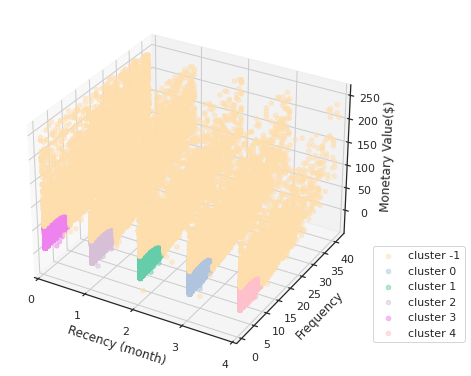

In [14]:
# step 4_1: data preparation
R=[]
F=[]
M=[]
mycolors=['navajowhite','lightsteelblue','mediumaquamarine','thistle', 'violet', 'pink']
cluster_orders=[-1,0,1,2,3,4]
for i in range(len(cluster_orders)):
    R.append(df_RFM_dbscan.loc[df_RFM_dbscan.clusters==cluster_orders[i],'Recency'].values.tolist())
    F.append(df_RFM_dbscan.loc[df_RFM_dbscan.clusters==cluster_orders[i],'Frequency'].values.tolist())
    M.append(df_RFM_dbscan.loc[df_RFM_dbscan.clusters==cluster_orders[i],'Monetary'].values.tolist())
    
# step 4_2: 3D scatter plot
fig=plt.figure(figsize=(8,5))
ax=Axes3D(fig)
for i in range(len(cluster_orders)):
    ax.scatter(R[i], F[i], M[i], c=mycolors[i], marker='o',alpha=0.5,label='cluster '+str(cluster_orders[i]))
ax.set_xlabel('Recency (month)')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary Value($)')
ax.set_xlim(0,4)
ax.set_xticks(list(range(5)))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.2))
plt.show()

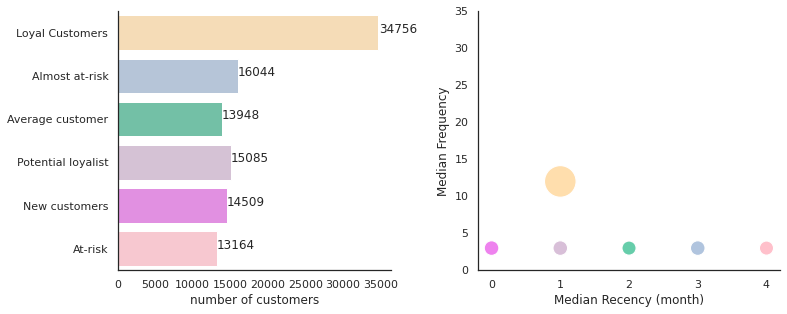

In [13]:
# replace k-means cluster names with more meaningful names
d1={-1:"Loyal Customers", 0:"Almost at-risk", 1:"Average customer", 2: "Potential loyalist", 3:"New customers", 4:"At-risk"}
df_RFM_dbscan.loc[:,"segments"]=df_RFM_dbscan.loc[:,"clusters"].map(d1)

# calculate the number of customers, median recency, median frequency, 
# and average customer spend in each customer segment
df_RFM4=df_RFM_dbscan.groupby('segments').agg(Recency=('Recency',np.median),Frequency=('Frequency',np.median),MonetarySum=('Monetary',np.sum),size=("clusters",'size'))
df_RFM4.loc[:,'Sales/Customer']=round(df_RFM4.loc[:,'MonetarySum']/df_RFM4.loc[:,'size'])
df_RFM4=df_RFM4.astype({'Sales/Customer':int}).reset_index()

# visualize
plt.figure(figsize=(10,4))
seg_names=['Loyal Customers','Almost at-risk','Average customer','Potential loyalist','New customers', 'At-risk']

# plot the number of customers in each segment
sns.set_style("white")
plt.axes([0, 0, 0.38, 0.9])
seg=df_RFM_dbscan.groupby('segments').size().to_frame().rename(columns={0:'number of customers'}).reset_index()
sns.barplot(x='number of customers',y='segments',data=seg,order=seg_names,palette=mycolors)
for i in range(len(cluster_orders)):
    number=int(seg.loc[seg.segments==seg_names[i],'number of customers'])
    x_pos=round(number,-2)
    plt.text(x_pos,i,number)
plt.ylabel("")
sns.despine()

# plot recency, frequency, and average spend/customer of the 4 segments
plt.axes([0.5,0,0.42,0.9])
sns.scatterplot(x='Recency',y='Frequency',hue='segments',hue_order=seg_names,palette=mycolors,size='Sales/Customer',sizes=(200,1000),legend=False,data=df_RFM4)
plt.ylim(0,35)
plt.xticks(list(range(5)))
# plt.text(1,29,'average "Loyal Customer": $146')
# plt.text(2,16,'average "Potential Loyalist": $72')
# plt.text(0,6,'average "New Customer": $24')
# plt.text(3,6,'average "At-Risk": $24')
plt.xlabel('Median Recency (month)')
plt.ylabel('Median Frequency')
sns.despine()

### Birch clustering algorithm

In [15]:
from sklearn.cluster import Birch

In [16]:
random.seed(8)
brc = Birch(n_clusters=4)
brc.fit(X)
random.seed(8)
pred_brc = brc.predict(X)

In [17]:
pred_brc

array([3, 3, 1, ..., 3, 3, 3])

/tmp/ipykernel_140677/3452080163.py:18: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax=Axes3D(fig)


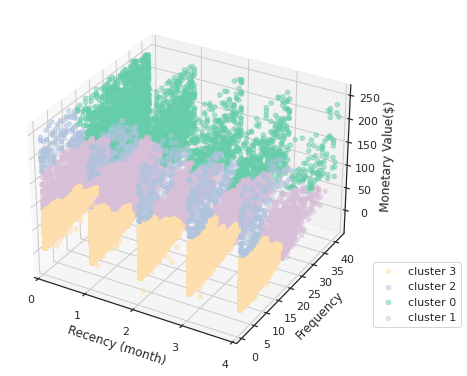

In [18]:
df_RFM2_birch=df_RFM2_original.assign(clusters=pred_brc)

# step 4: visualize the 4 clusters

# step 4_1: data preparation
R=[]
F=[]
M=[]
mycolors=['navajowhite','lightsteelblue','mediumaquamarine','thistle']
cluster_orders=[3,2,0,1]
for i in [0,1,2,3]:
    R.append(df_RFM2_birch.loc[df_RFM2_birch.clusters==cluster_orders[i],'Recency'].values.tolist())
    F.append(df_RFM2_birch.loc[df_RFM2_birch.clusters==cluster_orders[i],'Frequency'].values.tolist())
    M.append(df_RFM2_birch.loc[df_RFM2_birch.clusters==cluster_orders[i],'Monetary'].values.tolist())
    
# step 4_2: 3D scatter plot
fig=plt.figure(figsize=(8,5))
ax=Axes3D(fig)
for i in [0,1,2,3]:
    ax.scatter(R[i], F[i], M[i], c=mycolors[i], marker='o',alpha=0.5,label='cluster '+str(cluster_orders[i]))
ax.set_xlabel('Recency (month)')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary Value($)')
ax.set_xlim(0,4)
ax.set_xticks(list(range(5)))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.2))
plt.show()

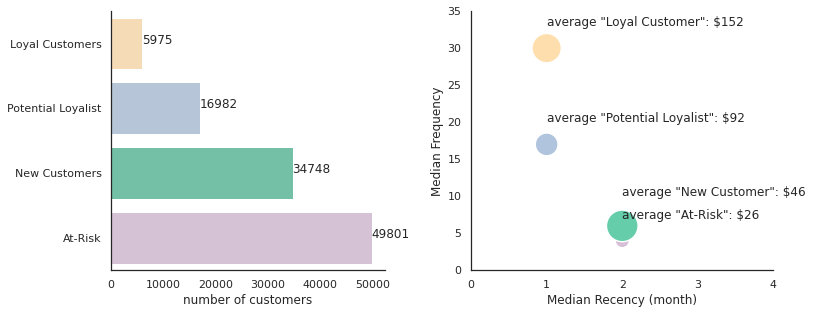

In [19]:
# replace k-means cluster names with more meaningful names
d1={0:"Loyal Customers", 2:"New Customers", 1: "Potential Loyalist", 3:"At-Risk"}
df_RFM2_birch.loc[:,"segments"]=df_RFM2_birch.loc[:,"clusters"].map(d1)

# calculate the number of customers, median recency, median frequency, 
# and average customer spend in each customer segment
df_RFM5=df_RFM2_birch.groupby('segments').agg(Recency=('Recency',np.median),Frequency=('Frequency',np.median),MonetarySum=('Monetary',np.sum),size=("clusters",'size'))
df_RFM5.loc[:,'Sales/Customer']=round(df_RFM5.loc[:,'MonetarySum']/df_RFM5.loc[:,'size'])
df_RFM5=df_RFM5.astype({'Sales/Customer':int}).reset_index()

# visualize
plt.figure(figsize=(10,4))
seg_names=['Loyal Customers','Potential Loyalist','New Customers','At-Risk']

# plot the number of customers in each segment
sns.set_style("white")
plt.axes([0, 0, 0.38, 0.9])
seg=df_RFM2.groupby('segments').size().to_frame().rename(columns={0:'number of customers'}).reset_index()
sns.barplot(x='number of customers',y='segments',data=seg,order=seg_names,palette=mycolors)
for i in [0,1,2,3]:
    number=int(seg.loc[seg.segments==seg_names[i],'number of customers'])
    x_pos=round(number,-2)
    plt.text(x_pos,i,number)
plt.ylabel("")
sns.despine()

# plot recency, frequency, and average spend/customer of the 4 segments
plt.axes([0.5,0,0.42,0.9])
sns.scatterplot(x='Recency',y='Frequency',hue='segments',hue_order=seg_names,palette=mycolors,size='Sales/Customer',sizes=(200,1000),legend=False,data=df_RFM5)
plt.ylim(0,35)
plt.xticks(list(range(5)))
plt.text(1,33,'average "Loyal Customer": $152')
plt.text(1,20,'average "Potential Loyalist": $92')
plt.text(2,10,'average "New Customer": $46')
plt.text(2,7,'average "At-Risk": $26')
plt.xlabel('Median Recency (month)')
plt.ylabel('Median Frequency')
sns.despine()

### Model Evaluation

In [25]:
labels_birch = brc.labels_
silh_score_birch = metrics.silhouette_score(X, labels_birch, metric='euclidean')
print('Silhouette score for Birch is '+str(silh_score_birch))

Silhouette score for Birch is 0.4196911465731402


In [26]:
davies_bouldin_birch = davies_bouldin_score(X, labels_birch)
print('Davies Bouldin score for Birch is '+str(davies_bouldin_birch))

Davies Bouldin score for Birch is 1.0493784126450685


### Compare all models

[Text(0, 0, '0.400198'), Text(0, 0, '0.241068'), Text(0, 0, '0.419691')]

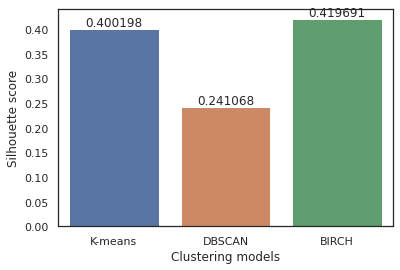

In [27]:
results_silh = {'Clustering models':['K-means','DBSCAN','BIRCH'],'Silhouette score':[silh_score_km,silh_score_dbscan,silh_score_birch]}
results_daviesb = {'Clustering models':['K-means','DBSCAN','BIRCH'],'Davies Bouldin score':[davies_bouldin_km, davies_bouldin_dbscan,davies_bouldin_birch]}

results_silh_df = pd.DataFrame.from_dict(results_silh)
results_daviesb_df = pd.DataFrame.from_dict(results_daviesb)

ax = sns.barplot(x='Clustering models', y='Silhouette score', data=results_silh_df)
ax.bar_label(ax.containers[0])


[Text(0, 0, '1.04403'), Text(0, 0, '1.11625'), Text(0, 0, '1.04938')]

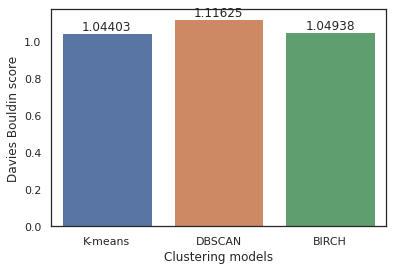

In [28]:
ax2 = sns.barplot(x='Clustering models', y='Davies Bouldin score', data=results_daviesb_df)
ax2.bar_label(ax2.containers[0])


### Part III: Examine the Relationship between the Probability of Purchasing and RFM

In [10]:

# step 1: calculate recency, Frequency, and Monetary in Oct 2019-Jan 2020
df_sales1=df_sales.loc[df_sales.month!='Feb',:].copy()
d={"Oct":3,"Nov":2,"Dec":1,"Jan":0}
df_sales1.loc[:,'Recency']=df_sales1.loc[:,'month'].map(d)
df_sales1_R=df_sales1.groupby('user_id')['Recency'].min().reset_index()
df_sales1_F=df_sales1.groupby('user_id')['event_type'].count().reset_index().rename(columns={'event_type':'Frequency'})
df_sales1_RF=pd.merge(df_sales1_R,df_sales1_F,on='user_id')
df_sales1_M=df_sales1.groupby('user_id')['price'].sum().reset_index().rename(columns={'price':"Monetary"})
df_sales2=pd.merge(df_sales1_RF,df_sales1_M,on='user_id')
                   
# step 2_1: find out customers who made purchases in Feb 2020
df_sales_feb_buyers=df_sales.loc[df_sales.month=='Feb','user_id'].unique().tolist()

# step 2_2: combine step 1 and step 2 results and remove outliers
df_sales2.loc[:,'Buy']=np.where(df_sales2['user_id'].isin(df_sales_feb_buyers),1,0)
conditions=np.abs(stats.zscore(df_sales2[['Recency','Frequency','Monetary']]) < 3).all(axis=1)
df_sales2=df_sales2.loc[conditions,:]
print("Shown below are the first 3 rows of the cleaned dataframe:\n")
display(df_sales2.head(3))

Shown below are the first 3 rows of the cleaned dataframe:



,user_id,Recency,Frequency,Monetary,Buy
0,9794320,2,2,7.72,0
1,10079204,2,2,25.81,0
2,10280338,0,11,52.82,1


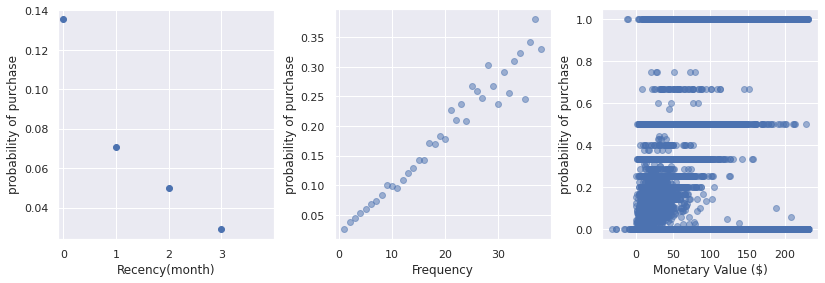

In [11]:
# Step 3 and 4: calculate and visualize the relationship between the probability of purchasing and RFM 
sns.set()
plt.figure(figsize=(12,4))

# plot purchase probability and Recency 
plt.axes([0,0,0.25,0.8])
df_Buy_R=df_sales2.groupby('Recency').agg(Number=('Buy','count'),Buy=('Buy','sum'))
df_Buy_R['Probability']=df_Buy_R['Buy']/df_Buy_R['Number']
plt.scatter(x=df_Buy_R.index,y=df_Buy_R.Probability)
plt.xlim(-0.1,4)
plt.xticks(np.arange(0,4,1))
plt.xlabel('Recency(month)')
plt.ylabel('probability of purchase')

# plot purchase probability and Frequency
plt.axes([0.32,0,0.25,0.8])
df_Buy_F=df_sales2.groupby('Frequency').agg(Number=('Buy','count'),Buy=('Buy','sum'))
df_Buy_F['Probability']=df_Buy_F['Buy']/df_Buy_F['Number']
plt.scatter(x=df_Buy_F.index,y=df_Buy_F.Probability,alpha=0.5)
plt.xlabel('Frequency')
plt.ylabel('probability of purchase')

# plot purchase probability and Monetary
plt.axes([0.63,0,0.25,0.8])
df_Buy_M=df_sales2.groupby('Monetary').agg(Number=('Buy','count'),Buy=('Buy','sum'))
df_Buy_M['Probability']=df_Buy_M['Buy']/df_Buy_M['Number']
plt.scatter(x=df_Buy_M.index,y=df_Buy_M.Probability,alpha=0.5)
plt.xlabel('Monetary Value ($)')
plt.ylabel("probability of purchase");